# 关于$\gamma$的估计发现的一点问题
之前估计的$\gamma$ 的精度一直不高, 而且精度经常不随样本变多而明显提高，尤其是第二个模型，最早一直认为是连续变量的系数估计的不够好，我最近发现应该是下面这些问题。

$y = X \alpha + Z \beta + g(X, Z) + 0.2\epsilon$

其中

$g_1 = log( 1 + exp( X \theta + Z \gamma - 1))$

$g_2 = cdf(0.1( X \theta + Z \gamma - 1)^2)$

$cdf(u)$ 为标准正态分布的累计密度函数

$Z = [z_1, z_2, z_3, z_4]$

$r$ ~ $U(0,1)$

$z_1 = 1$ when $r < P$

$z_2 = 1$ when $P < r < 2P$

$z_3 = 1$ when $2P < r < 3P$

$z_4 = 1$ when $3P < r < 4P$

$4P \leq 1$

这个定义下$4P = 1$时, 即没有取值全为0的$Z$

实验中发现，这种情况下$\gamma$解似乎不唯一


In [180]:
include("./src/qgplsim.ji")
include("./src/DGP.ji")
include("./src/supportFunctions.ji")

tabular (generic function with 2 methods)

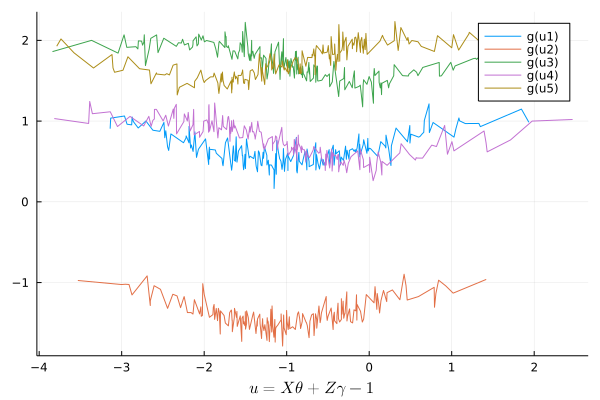

In [181]:
using LaTeXStrings

α = [1.0, -0.5] 
θ = [1.0, 2.0]  
θ = θ/norm(θ)
β = [1.0, -2.0, 1, 0] * 1.0 # 
γ = [2.0, 1.0, 0, 1] * 1.0 #

n = 1000
etp = 1
yx(x) = 2sin(x) 
ytp = 2
X, y, Z = xyz(n, α, β, θ, γ, etp, ytp)
catag, index = collection(Z)
ncateg = index.count

using Plots
plot()
for k in 1:ncateg
    zk = catag[k]
    indk = index[zk]
    Xk = X[indk, :]
    yk = y[indk] - Xk * α
    uk = Xk*θ  .- 1  # .+ zk' * γ
    ind = sortperm(uk)
    plot!(uk[ind], yk[ind], label = "g(u$k)")
end
xlabel!(L"u = X \theta + Z \gamma - 1")

In [182]:
τ = [0.5]
# τ = [0.25, 0.5, 0.75]
widthExp = -0.2
model1 = qgplsim.model(X, Z, y, τ, widthExp)
qgplsim.estimator(model1, method)
qgplsim.print_model(model1)

alpha => [0.9913, -0.515]
theta => [0.461, 0.8874]
gamma => [2.2356, 1.1754, 0.1941, 1.1016]
beta => [1.1454, -2.1675, 0.9292, -0.1756]


## 1. $Z$ 全不为0

In [850]:
q, p = length(α), length(γ) 
Alpha1 = zeros(n_repeat * nth, q)
Theta1 = zeros(n_repeat * nth, q)
Gamma1 = zeros(n_repeat * nth, p)

@threads for i in 1:nth
    for j in 1:n_repeat
        
        k = (i - 1) * n_repeat + j
        e = epsilon(n, 1)
        X, y, Z = xyz(n, α, θ, β, γ, 0.2e, 2)

        modelk = qgplsim.model(X, Z, y, tau, widthExp)
        qgplsim.estimator(modelk)
        Alpha1[k, :] = modelk.alpha
        Theta1[k, :] = modelk.theta
        Gamma1[k, :] = modelk.gamma

    end
end



In [851]:
EE1 = sqrt.(1 .- abs.(Theta1 * θ)) 
println(mean(EE1), " ", std(EE1))

0.02775354502967506 0.01884136129719654


In [852]:
println("θ is \n", round.(θ, digits = 4))
println("mean value of 100 times estimation of θ is \n", 
         round.(mean(Theta1, dims = 1), digits = 4))

θ is 
[0.8944, 0.4472]
mean value of 100 times estimation of θ is 
[0.8906 0.4524]


In [853]:
println("α is \n", round.(α, digits = 4))
println("mean value of 100 times estimation of α is \n", 
         round.(mean(Alpha1, dims = 1), digits = 4))

α is 
[1.0, -2.0]
mean value of 100 times estimation of α is 
[1.0104 -1.9894]


In [854]:
println("γ is \n", round.(γ, digits = 4))
println("mean value of 100 times estimation of γ is \n", 
         round.(mean(Gamma1, dims = 1), digits = 4))

γ is 
[-1.0, 2.0, 1.0, 0.0]
mean value of 100 times estimation of γ is 
[-1.2859 1.3992 0.4685 -0.5818]


## 2. 一部分 的 $Z$ 为 0

In [880]:
q, p = length(α), length(γ) 
Alpha1 = zeros(n_repeat * nth, q)
Theta1 = zeros(n_repeat * nth, q)
Gamma1 = zeros(n_repeat * nth, p)
Beta1 = zeros(n_repeat * nth, p)

zpz = 0.02
@threads for i in 1:nth
    for j in 1:n_repeat
        
        k = (i - 1) * n_repeat + j
        e = epsilon(n, 1)
        X, y, Z = xyz(n, α, θ, β, γ, 0.2e, 2, zpz)

        modelk = qgplsim.model(X, Z, y, tau, widthExp)
        qgplsim.estimator(modelk, method)
        Alpha1[k, :] = modelk.alpha
        Theta1[k, :] = modelk.theta
        Gamma1[k, :] = modelk.gamma
        Beta1[k,:] = modelk.beta

    end
end



In [881]:
EE1 = sqrt.(1 .- abs.(Theta1 * θ)) 
println(mean(EE1), " ", std(EE1))

0.027840467252803393 0.03005982928467148


In [882]:
println("θ is \n", round.(θ, digits = 4))
println("mean value of 100 times estimation of θ is \n", 
         round.(mean(Theta1, dims = 1), digits = 4))

θ is 
[0.8944, 0.4472]
mean value of 100 times estimation of θ is 
[0.8938 0.4447]


In [883]:
println("α is \n", round.(α, digits = 4))
println("mean value of 100 times estimation of α is \n", 
         round.(mean(Alpha1, dims = 1), digits = 4))

α is 
[1.0, -2.0]
mean value of 100 times estimation of α is 
[0.9925 -1.996]


In [884]:
println("β is \n", round.(β, digits = 4))
println("mean value of 100 times estimation of β is \n", 
         round.(mean(Beta1, dims = 1), digits = 4))

β is 
[1.0, 1.0, -1.0, 0.0]
mean value of 100 times estimation of β is 
[1.0829 0.9402 -1.0937 0.0006]


In [885]:
println("γ is \n", round.(γ, digits = 4))
println("mean value of 100 times estimation of γ is \n", 
         round.(mean(Gamma1, dims = 1), digits = 4))

γ is 
[-1.0, 2.0, 1.0, 0.0]
mean value of 100 times estimation of γ is 
[-0.5677 1.3065 0.7382 -0.0697]


## Monte Carlo

In [26]:
using Base.Threads

In [117]:
include("./src/qgplsim.ji")
include("./src/DGP.ji")
N = [500, 1000]
Etype = [1,2,3,4]
ytype = 1
len_n = length(N)
len_e = length(Etype)

meanEE_theta = zeros(len_n, len_e)
stdEE_theta = zeros(len_n, len_e)

mean_alpha = zeros(len_n, len_e)
std_alpha = zeros(len_n, len_e)

mean_gamma = zeros(len_n, len_e)
std_gamma = zeros(len_n, len_e)

mean_beta = zeros(len_n, len_e)
std_beta = zeros(len_n, len_e)

n_repeat = 100
widthExp = -0.2

α = [1, -2]
θ = [2, 1]/sqrt(5)
β = [1.0, -2.0, 1.0, 1.0, 0.0] * 1.0
γ = [1.0, 1.0, 1.0, 0.0, 1.0]  * 1.0
tau = [0.5]

p = length(α)
q = length(β)

@threads for j in 1:len_e
    
    etype = Etype[j]    
    
    for i in 1:len_n  

        n = N[i] 
       
        Alpha = zeros(n_repeat, p)
        Theta = zeros(n_repeat, p)
        Beta = zeros(n_repeat, q)
        Gamma = zeros(n_repeat, q)
        
        for k in 1:n_repeat
            
            X, y, Z = xyz(n, α, β, θ, γ, etype, ytype)
            modelk = qgplsim.model(X, Z, y, tau, widthExp)
            qgplsim.estimator(modelk)
            Alpha[k, :] = modelk.alpha
            Theta[k, :] = modelk.theta
            Beta[k, :] = modelk.beta
            Gamma[k,:] = modelk.gamma
            
        end
        # println(mean(Gamma, dims = 1))
        EE = sqrt.(1 .- abs.(Theta * θ)) 
        meanEE_theta[i,j] = mean(EE)
        stdEE_theta[i,j] = std(EE)
        mean_alpha[i,j], std_alpha[i,j] = euclid(Alpha, α)
        mean_gamma[i,j], std_gamma[i,j] = euclid(Gamma, γ)
        mean_beta[i,j], std_beta[i,j] = euclid(Beta, β)

        
    end
end

In [118]:
table_alpha = tabular(mean_alpha, std_alpha)

2×4 Matrix{String}:
 "0.0296(.0195)"  "0.0132(.0107)"  "0.0524(.1081)"  "0.1286(.2063)"
 "0.0171(.0126)"  "0.0076(.0056)"  "0.0466(.1614)"  "0.0664(.1769)"

In [119]:
table_beta = tabular(mean_beta, std_beta)

2×4 Matrix{String}:
 "0.0688(.0373)"  "0.0392(.0156)"  "0.1084(.1370)"  "0.1511(.1441)"
 "0.0453(.0200)"  "0.0283(.0111)"  "0.1126(.2152)"  "0.1062(.1216)"

In [120]:
table_theta = tabular(meanEE_theta, stdEE_theta)

2×4 Matrix{String}:
 "0.0205(.0137)"  "0.0091(.0075)"  "0.0371(.0786)"  "0.0964(.1723)"
 "0.0118(.0088)"  "0.0052(.0039)"  "0.0364(.1352)"  "0.0510(.1479)"

In [121]:
table_gamma = tabular(mean_gamma, std_gamma)

2×4 Matrix{String}:
 "0.1868(.1016)"  "0.1528(.0702)"  "0.1712(.0758)"  "0.1882(.1712)"
 "0.1343(.0693)"  "0.1226(.0480)"  "0.1646(.2539)"  "0.1450(.2108)"

In [116]:
table_sum = [table_alpha; table_theta; table_beta; table_gamma]

8×4 Matrix{String}:
 "0.0301(.0217)"  "0.0111(.0082)"  "0.0417(.1316)"   "0.0906(.1438)"
 "0.0154(.0114)"  "0.0081(.0058)"  "0.0326(.1190)"   "0.0425(.1008)"
 "0.0212(.0155)"  "0.0077(.0058)"  "0.0319(.1103)"   "0.0664(.1145)"
 "0.0108(.0081)"  "0.0057(.0042)"  "0.0258(.1079)"   "0.0308(.0782)"
 "0.0445(.0226)"  "0.0289(.0174)"  "0.0810(.1049)"   "0.1113(.0844)"
 "0.0403(.0680)"  "0.0239(.0126)"  "3.6790(5.0137)"  "0.0905(.0656)"
 "0.1968(.1196)"  "0.1671(.0813)"  "0.1772(.0870)"   "0.1787(.1896)"
 "0.1764(.0986)"  "0.1490(.0888)"  "0.1587(.0787)"   "0.1407(.0660)"

In [98]:
using DataFrames, CSV
df = DataFrame(table_sum)
CSV.write("model2z.csv", df)

"model2z.csv"